In [1]:
# How to visualise?
# https://pypi.org/project/nipet/
# https://www.frontiersin.org/articles/10.3389/fninf.2018.00064/full
# https://github.com/marcomusy/vedo
# https://stackoverflow.com/questions/56035562/3d-dicom-visualisation-in-python
# https://www.youtube.com/watch?v=Tc9ONZLBHP0

# Saliency map?
# https://medium.com/@zeh.henrique92/basic-exploration-and-visualization-of-lung-ct-scans-with-python-e86b8d665bb6

In [2]:
import seaborn
seaborn.__version__

'0.11.1'

TODO:
    * https://towardsdatascience.com/deep-learning-with-magnetic-resonance-and-computed-tomography-images-e9f32273dcb5
    * https://nilearn.github.io/manipulating_images/input_output.html
    * https://nilearn.github.io/auto_examples/plot_nilearn_101.html
    * https://vincentblog.xyz/posts/medical-images-in-python-computed-tomography?fbclid=IwAR33Nmfoq_u0RcdaXUSEWaJ4PlCOedqHafZnKTnQOQQk5mUuLC9LPvTaziU
    * https://nilearn.github.io/building_blocks/manual_pipeline.html
    * https://pandas.pydata.org/pandas-docs/version/0.13.1/visualization.html#targeting-different-subplots

In [3]:
# Fix relative import for utils
import sys
if '..' not in sys.path:
    sys.path.append('..')

In [4]:
from utils import dataloader
from utils import display as dplay
from utils.adni import ADNI

import os
import numpy as np
import pandas as pd
from IPython.display import display 
import matplotlib.pyplot as plt
import seaborn as sns
base_dir = '../data'

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
adni = ADNI(base_dir)

# Load data

In [7]:
adni.load(show_output=False)

## Display MetaData

In [8]:
meta_df = adni.meta_to_df()

Processing type of:
	 float: subject.study.subjectAge
	 float: subject.study.weightKg
	 float: subject.visit.assessment.component.assessmentScore_MMSCORE
	 float: subject.visit.assessment.component.assessmentScore_GDTOTAL
	 float: subject.visit.assessment.component.assessmentScore_CDGLOBAL
	 float: subject.visit.assessment.component.assessmentScore_NPISCORE
	 float: subject.visit.assessment.component.assessmentScore_FAQTOTAL
	 category: subject.researchGroup
	 string: subject.subjectSex
	 datetime64[ns]: subject.study.series.dateAcquired


In [9]:
dplay.display_all_pd_cols(meta_df)

,projectIdentifier,projectDescription,siteKey,subject.subjectIdentifier,subject.researchGroup,subject.subjectSex,subject.subjectInfo_APOE A1,subject.subjectInfo_APOE A2,subject.visit.visitIdentifier,subject.study.studyIdentifier,subject.study.subjectAge,subject.study.ageQualifier,subject.study.weightKg,subject.study.postMortem,subject.study.series.seriesIdentifier,subject.study.series.modality,subject.study.series.dateAcquired,subject.study.imagingProtocol.imageUID,subject.study.imagingProtocol.description,subject.study.imagingProtocol.protocolTerm.protocol_Manufacturer,subject.study.imagingProtocol.protocolTerm.protocol_Mfg Model,subject.study.imagingProtocol.protocolTerm.protocol_Radiopharmaceutical,subject.study.imagingProtocol.protocolTerm.protocol_Number of Rows,subject.study.imagingProtocol.protocolTerm.protocol_Number of Columns,subject.study.imagingProtocol.protocolTerm.protocol_Number of Slices,subject.study.imagingProtocol.protocolTerm.protocol_Frames,subject.study.imagingProtocol.protocolTerm.protocol_Pixel Spacing X,subject.study.imagingProtocol.protocolTerm.protocol_Pixel Spacing Y,subject.study.imagingProtocol.protocolTerm.protocol_Slice Thickness,subject.study.imagingProtocol.protocolTerm.protocol_Counts Source,subject.study.imagingProtocol.protocolTerm.protocol_Randoms Correction,subject.study.imagingProtocol.protocolTerm.protocol_Attenuation Correction,subject.study.imagingProtocol.protocolTerm.protocol_Decay Correction,subject.study.imagingProtocol.protocolTerm.protocol_Reconstruction,subject.study.imagingProtocol.protocolTerm.protocol_Scatter Correction,subject.study.imagingProtocol.protocolTerm.protocol_Radioisotope,subject.visit.assessment.component.assessmentScore_MMSCORE,subject.visit.assessment.component.assessmentScore_GDTOTAL,subject.visit.assessment.component.assessmentScore_CDGLOBAL,subject.visit.assessment.component.assessmentScore_FAQTOTAL,subject.study.imagingProtocol.protocolTerm.protocol_Convolution Kernel,subject.visit.assessment.component.assessmentScore_NPISCORE
10,ADNI,Alzheimer's Disease Neuroimaging Initiative,002,002_S_0295,CN,M,3,4,ADNI2 Initial Visit-Cont Pt,34489,90.0493,Y,73.0284,F,111104,PET,2011-06-09,I239487,ADNI Brain PET: Raw FDG,Philips Medical Systems,GEMINI TF TOF 16,18F-FDG,128.0,128.0,90.0,6.0,2.0,2.0,2.0,EMISSION,DLYD,CTAC-SG,START,LOR-RAMLA,SS-SIMUL,F-18,28.0,1.0,0.0,0.0,NaN,NaN
22,ADNI,Alzheimer's Disease Neuroimaging Initiative,002,002_S_0413,CN,F,3,3,ADNI2 Initial Visit-Cont Pt,34753,81.5151,Y,57.6062,F,111993,PET,2011-06-17,I240813,ADNI Brain PET: Raw FDG,Philips Medical Systems,GEMINI TF TOF 16,18F-FDG,128.0,128.0,90.0,6.0,2.0,2.0,2.0,EMISSION,DLYD,CTAC-SG,START,LOR-RAMLA,SS-SIMUL,F-18,30.0,1.0,0.0,1.0,NaN,NaN
18,ADNI,Alzheimer's Disease Neuroimaging Initiative,002,002_S_0413,CN,F,3,3,ADNI2 Year 2 Visit,58439,83.4247,Y,58.0598,F,189346,PET,2013-05-14,I384425,ADNI Brain PET: Raw FDG,Philips Medical Systems,GEMINI TF TOF 16,18F-FDG,128.0,128.0,90.0,6.0,2.0,2.0,2.0,EMISSION,DLYD,CTAC-SG,START,LOR-RAMLA,SS-SIMUL,F-18,30.0,0.0,0.0,0.0,NaN,NaN
45,ADNI,Alzheimer's Disease Neuroimaging Initiative,002,002_S_0685,CN,F,3,3,ADNI1/GO Month 48,27961,93.7973,Y,69.3996,F,89586,PET,2010-07-27,I187652,ADNI Brain PET: Raw FDG,Philips Medical Systems,GEMINI TF TOF 16,18F-FDG,128.0,128.0,90.0,6.0,2.0,2.0,2.0,EMISSION,DLYD,CTAC-SG,START,LOR-RAMLA,SS-SIMUL,F-18,28.0,1.0,0.0,0.0,NaN,0.0
13,ADNI,Alzheimer's Disease Neuroimaging Initiative,002,002_S_0685,CN,F,3,3,ADNI2 Year 1 Visit,48136,95.8164,Y,68.9000,F,159368,PET,2012-08-02,I321228,ADNI Brain PET: Raw FDG,Philips Medical Systems,GEMINI TF TOF 16,18F-FDG,128.0,128.0,90.0,6.0,2.0,2.0,2.0,EMISSION,DLYD,CTAC-SG,START,LOR-RAMLA,SS-SIMUL,F-18,28.0,1.0,NaN,NaN,NaN,NaN


# Display ImageFiles

In [10]:
files_df = adni.files_to_df()

In [11]:
dplay.display_all_pd_cols(files_df)

,projectIdentifier,subject.subjectIdentifier,subject.study.series.modality,subject.study.imagingProtocol.description,subject.study.series.dateAcquiredPrecise,image_nbr,series,subject.study.imagingProtocol.imageUID,filename,path
0,ADNI,002_S_0685,PT,ADNI_Brain_PET__Raw_FDG,20100728032905315,38,S89586,I187652,ADNI_002_S_0685_PT_ADNI_Brain_PET__Raw_FDG_br_...,../data/adni_raw/002_S_0685/ADNI_Brain_PET__Ra...
1,ADNI,002_S_0685,PT,ADNI_Brain_PET__Raw_FDG,20100728032900663,407,S89586,I187652,ADNI_002_S_0685_PT_ADNI_Brain_PET__Raw_FDG_br_...,../data/adni_raw/002_S_0685/ADNI_Brain_PET__Ra...
2,ADNI,002_S_0685,PT,ADNI_Brain_PET__Raw_FDG,20100728032905220,143,S89586,I187652,ADNI_002_S_0685_PT_ADNI_Brain_PET__Raw_FDG_br_...,../data/adni_raw/002_S_0685/ADNI_Brain_PET__Ra...
3,ADNI,002_S_0685,PT,ADNI_Brain_PET__Raw_FDG,20100728032903068,331,S89586,I187652,ADNI_002_S_0685_PT_ADNI_Brain_PET__Raw_FDG_br_...,../data/adni_raw/002_S_0685/ADNI_Brain_PET__Ra...
4,ADNI,002_S_0685,PT,ADNI_Brain_PET__Raw_FDG,20100728032900643,506,S89586,I187652,ADNI_002_S_0685_PT_ADNI_Brain_PET__Raw_FDG_br_...,../data/adni_raw/002_S_0685/ADNI_Brain_PET__Ra...


# Save Images to adni folder as categorised data

In [12]:
df = adni.to_df(show_output=False)
adni.save_to_category(df)

Copy files: 
	root: ../data/adni/
	AD: ../data/adni/AD/
	CN: ../data/adni/CN/
	MCI: ../data/adni/MCI/
Statistics:
    AD:
        Skip: 60
        Transfer: 0
    CN:
        Skip: 60
        Transfer: 0
    MCI:
        Skip: 139
        Transfer: 0


# Analysis

### Overview

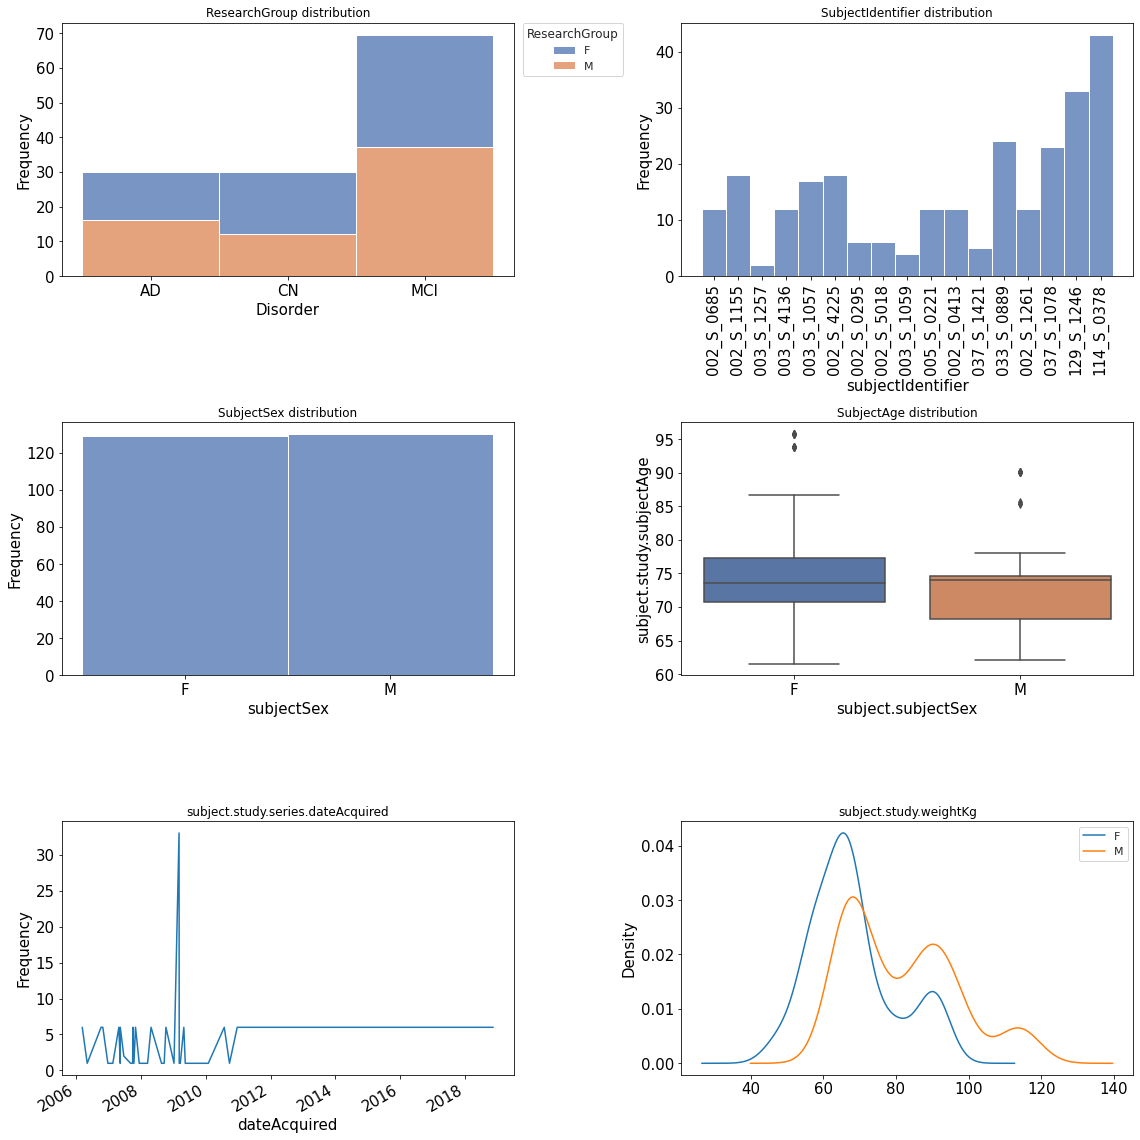

In [13]:
fig, axes = dplay.plot_meta_settings(rows=3)

#df['subject.researchGroup'].value_counts().plot(kind='bar',
#                                    ax=axes[0,0],
#                                    title="subject.researchGroup", xlabel="Disorder", ylabel="Frequency")
dplay.do_histplot(
    df, 
    x='subject.researchGroup', 
    hue='subject.subjectSex',
    ax=axes[0,0],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'ResearchGroup distribution','xlabel':'Disorder'}
)



#df['subject.subjectIdentifier'].value_counts().plot(kind='bar',
#                                    ax=axes[0,1],
#                                    title="subject.subjectIdentifier", xlabel="subjectIdentifier", ylabel="Frequency")

dplay.do_histplot(
    df, 
    x='subject.subjectIdentifier', 
    ax=axes[0,1],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'SubjectIdentifier distribution','xlabel':'subjectIdentifier','rotation':90}
)

#df['subject.subjectSex'].value_counts().plot(kind='bar',
#                                    ax=axes[1,0],
#                                    title="subject.subjectSex", xlabel="subjectSex", ylabel="Frequency")

dplay.do_histplot(
    df, 
    x='subject.subjectSex', 
    ax=axes[1,0],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'SubjectSex distribution','xlabel':'subjectSex'}
)

dplay.do_boxplot(
    df, 
    y='subject.study.subjectAge',
    x='subject.subjectSex',
    discrete=True,
    ax=axes[1,1],
    plot_kws={},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'SubjectAge distribution'}
)


df['subject.study.series.dateAcquired'].value_counts().plot(
                                    ax=axes[2,0],
                                    title="subject.study.series.dateAcquired", xlabel="dateAcquired", ylabel="Frequency")


df.groupby('subject.subjectSex')['subject.study.weightKg'].plot(kind='kde',
                                    ax=axes[2,1],
                                    title="subject.study.weightKg", xlabel="weightKg", ylabel="Frequency",legend=True)



plt.show()

### Data sizes

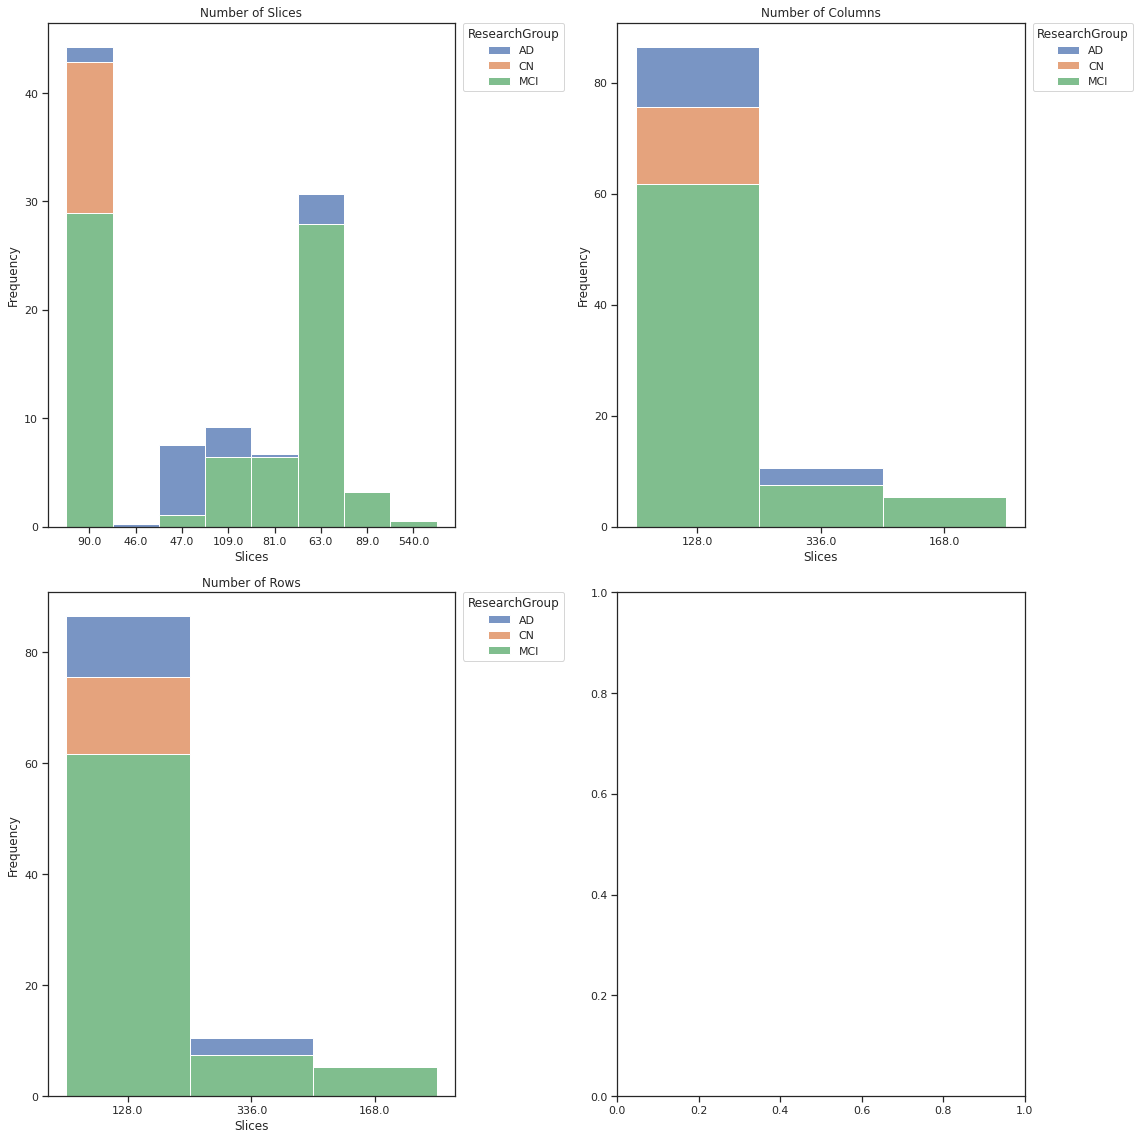

In [14]:
fig, axes = dplay.plot_meta_settings(rows=2)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.study.imagingProtocol.protocolTerm.protocol_Number of Slices', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[0,0],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Number of Slices','xlabel':'Slices','ylabel':'Frequency'}
)
dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.study.imagingProtocol.protocolTerm.protocol_Number of Columns', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[0,1],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Number of Columns','xlabel':'Slices','ylabel':'Frequency'}
)
dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.study.imagingProtocol.protocolTerm.protocol_Number of Rows', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[1,0],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Number of Rows','xlabel':'Slices','ylabel':'Frequency'}
)
plt.show()

### Scoring

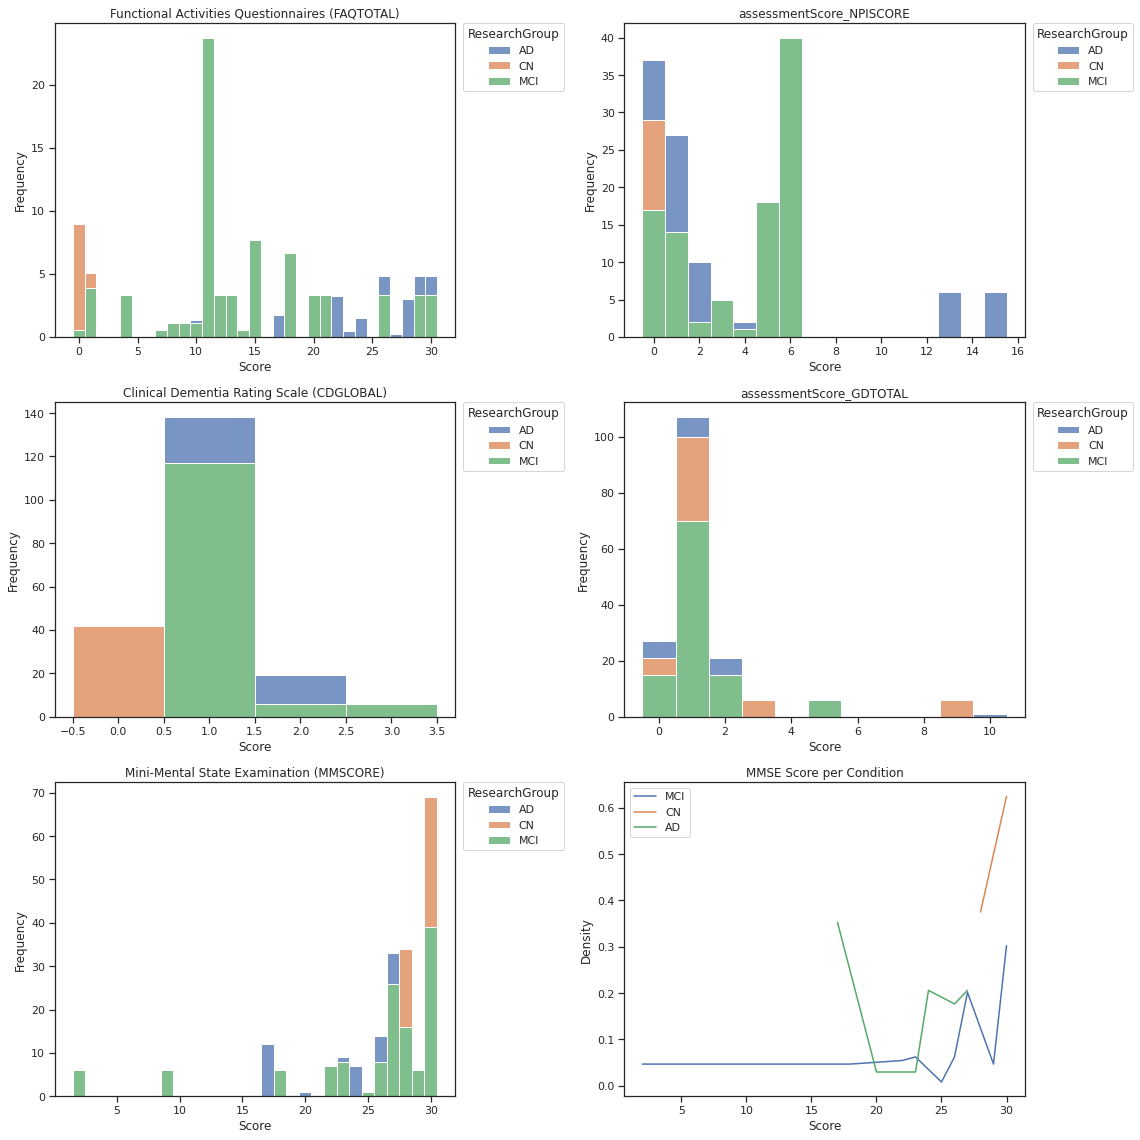

In [15]:
fig, axes = dplay.plot_meta_settings(rows=3)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.visit.assessment.component.assessmentScore_FAQTOTAL', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[0,0],
    plot_kws={'stat':'frequency'},
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Functional Activities Questionnaires (FAQTOTAL)','xlabel':'Score','ylabel':'Frequency'}
)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.visit.assessment.component.assessmentScore_NPISCORE', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[0,1],
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'assessmentScore_NPISCORE','xlabel':'Score','ylabel':'Frequency'}
)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.visit.assessment.component.assessmentScore_CDGLOBAL', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[1,0],
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Clinical Dementia Rating Scale (CDGLOBAL)','xlabel':'Score','ylabel':'Frequency'}
)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.visit.assessment.component.assessmentScore_GDTOTAL', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[1,1],
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'assessmentScore_GDTOTAL','xlabel':'Score','ylabel':'Frequency'}
)

dplay.do_histplot(
    df, 
    discrete=True,
    x='subject.visit.assessment.component.assessmentScore_MMSCORE', 
    hue='subject.researchGroup', 
    multiple='stack',
    ax=axes[2,0],
    legend_kws={'title':'ResearchGroup'},
    setting_kws={'title':'Mini-Mental State Examination (MMSCORE)','xlabel':'Score','ylabel':'Frequency'}
)

for condition in ['MCI', 'CN', 'AD']:
    values = df[df['subject.researchGroup'] == condition]['subject.visit.assessment.component.assessmentScore_MMSCORE'].value_counts()
    (values / values.sum()).sort_index().plot(
                                    ax=axes[2,1],
                                    legend=True,
                                    title="MMSE Score per Condition", xlabel="Score", ylabel="Density", label=condition)

plt.show()

## Visualise brain slices

### Create Image generator

In [16]:
SKIP_LAYERS = 10
LIMIT_LAYERS = 70

In [17]:
image_AD_generator = adni.get_images(list(adni.get_files(adni.path.category['AD'], adni.category_cols)))
image_CN_generator = adni.get_images(list(adni.load_files(adni.path.category['CN'], adni.category_cols)))
image_MCI_generator = adni.get_images(list(adni.load_files(adni.path.category['MCI'], adni.category_cols)))

Root path: ../data/adni/AD/
Loaded files: 60
Columns:
	subject.researchGroup
	subject.subjectIdentifier
	subject.study.imagingProtocol.imageUID
	image_nbr
	filename
	path
Root path: ../data/adni/CN/
Loaded files: 60
Columns:
	subject.researchGroup
	subject.subjectIdentifier
	subject.study.imagingProtocol.imageUID
	image_nbr
	filename
	path
Root path: ../data/adni/MCI/
Loaded files: 139
Columns:
	subject.researchGroup
	subject.subjectIdentifier
	subject.study.imagingProtocol.imageUID
	image_nbr
	filename
	path


In [18]:
### Testing functions
from nilearn.plotting import view_img, plot_glass_brain, plot_anat, plot_epi

In [19]:
all_image = adni.get_images()

In [20]:
test_image = next(all_image)

In [21]:
test_image.shape

(128, 128, 90, 1)

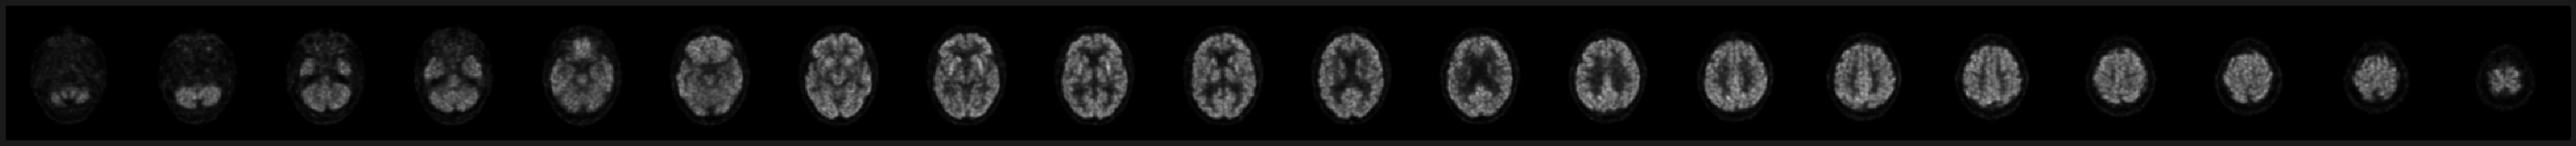

In [22]:
plot_anat(test_image, draw_cross=False, display_mode='z',cut_coords=20,annotate=False)

In [23]:
images_AD_array = adni.to_array(list(image_AD_generator))
images_CN_array = adni.to_array(list(image_CN_generator))
images_MCI_array = adni.to_array(list(image_MCI_generator))

In [24]:
images_AD = next(images_AD_array)[0]
images_CN = next(images_CN_array)[0]
images_MCI = next(images_CN_array)[0]

### Coronal plane (From top)

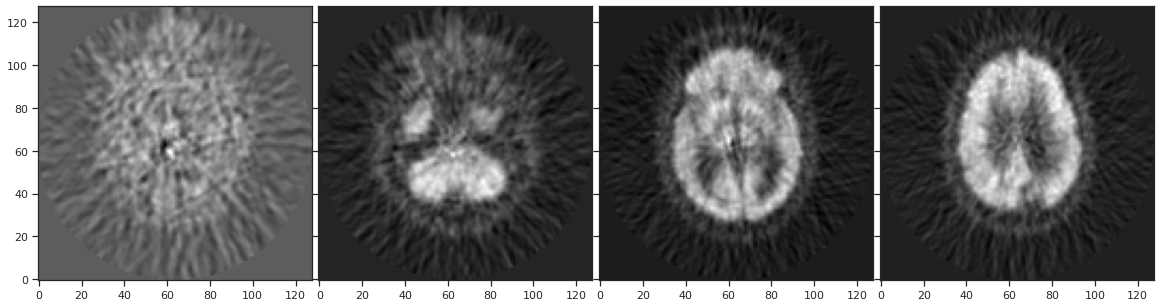

Text(0.5, 0.98, 'Coronal plane - AD')

<Figure size 432x288 with 0 Axes>

In [34]:

image_AD_slices = [images_AD[layer,:,:] for layer in range(0,images_AD.shape[0],SKIP_LAYERS)]
dplay.display_advanced_plot(image_AD_slices)
plt.suptitle("Coronal plane - AD")  

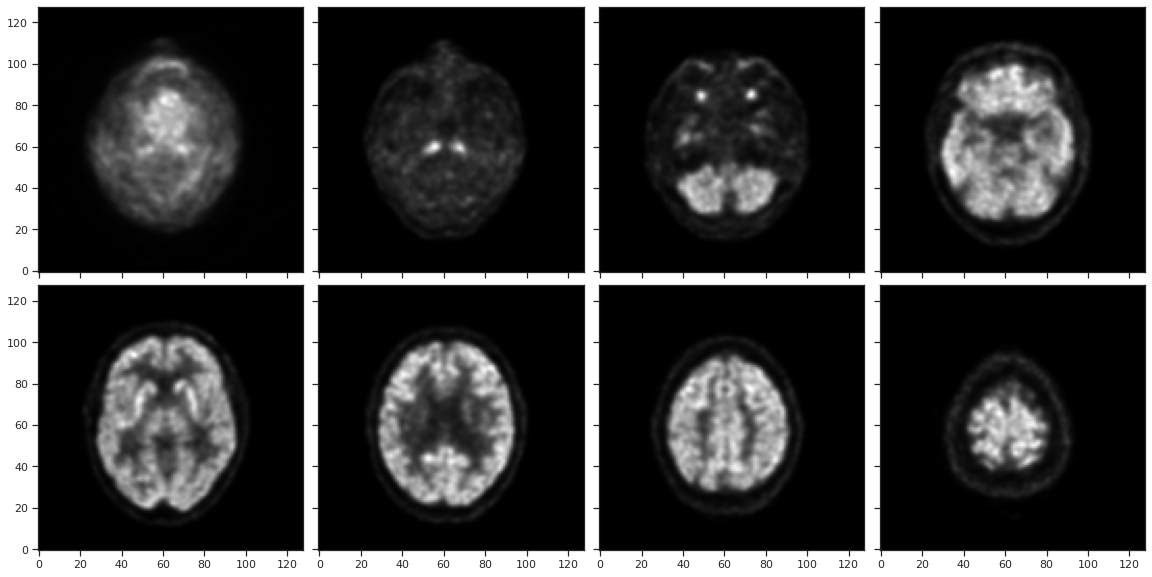

Text(0.5, 0.98, 'Coronal plane - CN')

<Figure size 432x288 with 0 Axes>

In [26]:

image_CN_slices = [images_CN[layer,:,:] for layer in range(0,images_CN.shape[0],SKIP_LAYERS)]
dplay.display_advanced_plot(image_CN_slices)
plt.suptitle("Coronal plane - CN")  

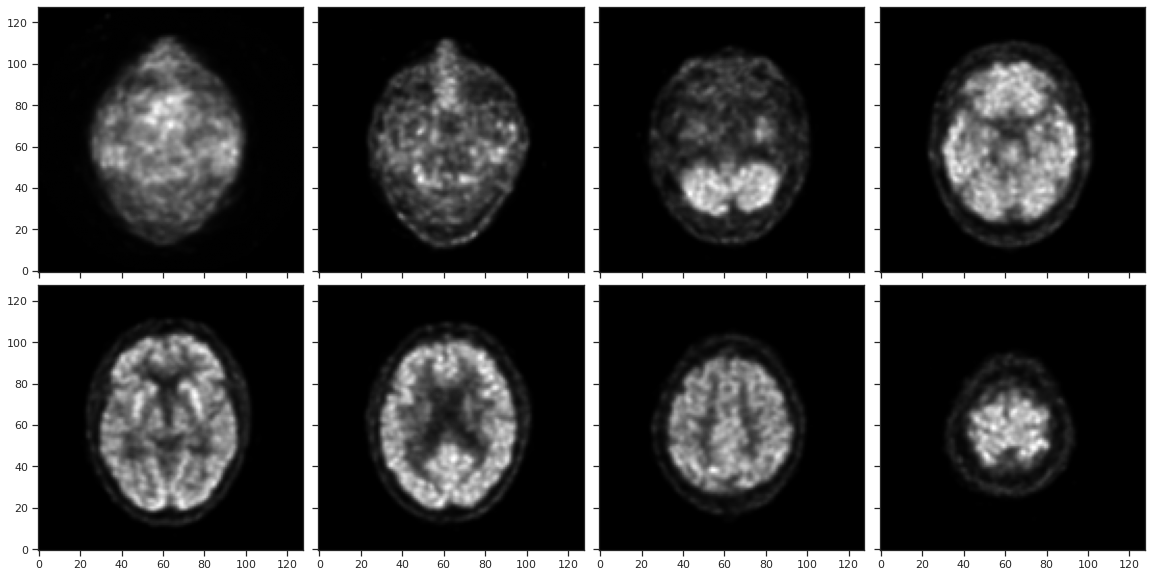

Text(0.5, 0.98, 'Coronal plane - MCI')

<Figure size 432x288 with 0 Axes>

In [27]:
image_MCI_slices = [images_MCI[layer,:,:] for layer in range(0,images_MCI.shape[0],SKIP_LAYERS)]
dplay.display_advanced_plot(image_MCI_slices)
plt.suptitle("Coronal plane - MCI")  

### Sagittal plane (From front)

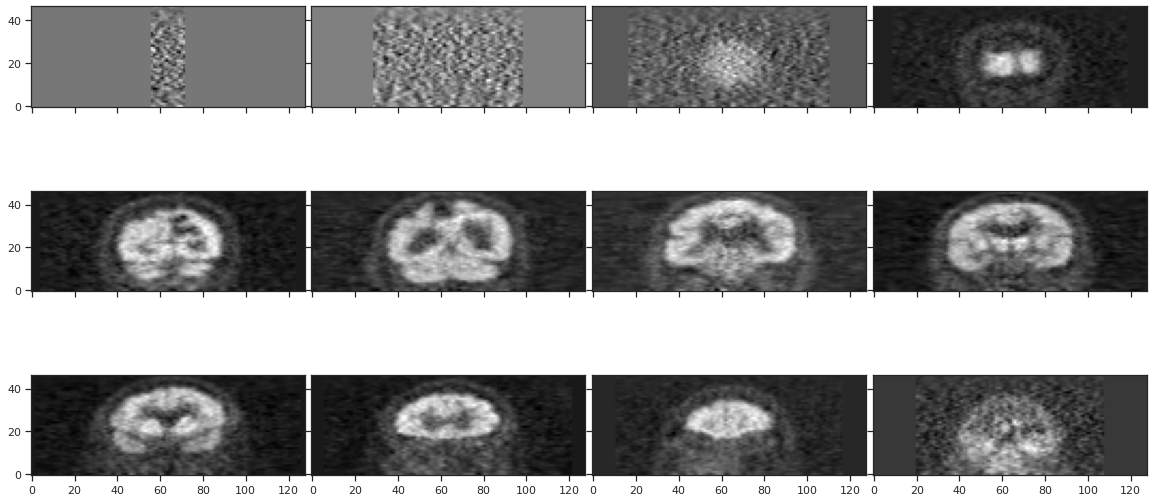

Text(0.5, 0.98, 'Sagittal plane')

<Figure size 432x288 with 0 Axes>

In [28]:
image_slices = [images_AD[:,layer,:] for layer in range(0,images_AD.shape[1], SKIP_LAYERS)]
dplay.display_advanced_plot(image_slices)
plt.suptitle("Sagittal plane")  

### Horisontal plane (from side)

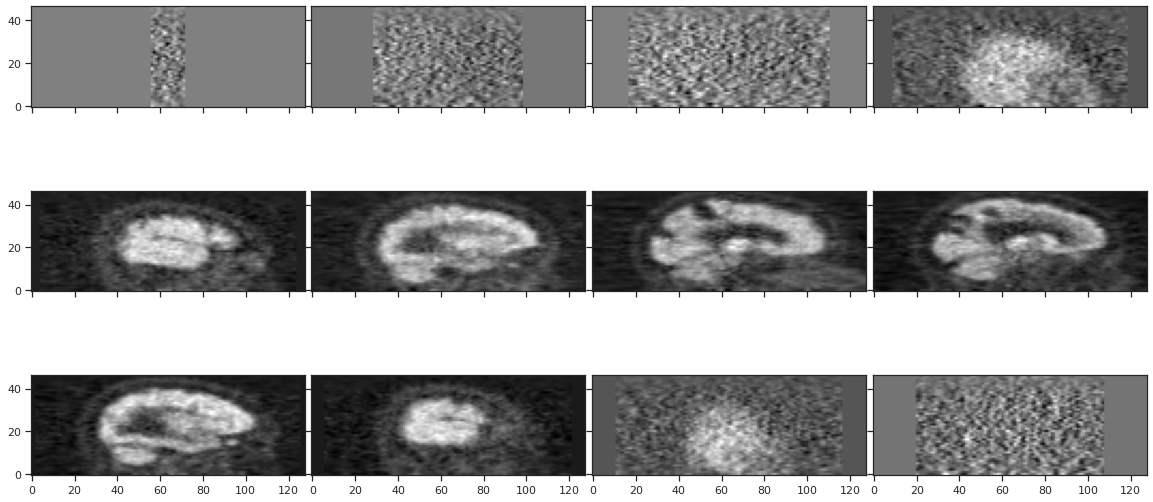

Text(0.5, 0.98, 'Horisonal plane')

<Figure size 432x288 with 0 Axes>

In [29]:
image_slices = [images_AD[:,:,layer] for layer in range(0,images_AD.shape[2], SKIP_LAYERS)]
dplay.display_advanced_plot(image_slices)
plt.suptitle("Horisonal plane")  

# Notes
* Dont take 60 min dynamic - Iter(Brain Mod

In [30]:
# Can we see a difference between MCI, CN and AD?

In [31]:
# How is the images before preprocess?

In [32]:
# How is the images after preprocess?

In [33]:
# Distribution? (Can be text as well)